# Advanced usage of recurrent neural networks

В этом разделе мы рассмотрим два передовых метода для повышения производительности и обобщающей способности рекуррентных нейронных
сетей. К концу раздела вы узнаете большую часть информации об использовании рекуррентных сетей с Keras. Мы 
продемонстрируем все концепции проблемы прогнозирования погоды, где у нас есть доступ к временному ряду данных, поступающих от датчиков
установленых на крыше здания, например, температура, давление воздуха и влажность, которые мы используем, чтобы предсказать, какая температура будет
24 часа после последнего сбора данных. Это довольно сложная проблема, которая иллюстрирует многие общие трудности, с которыми сталкиваются
при работе со временными.

Мы рассмотрим следующие методы:

* * Recurrent dropout *, специальный встроенный способ использования dropout для борьбы с переобучением в повторяющихся слоях.
* * Укладка повторяющихся слоев *, для увеличения представительной мощности сети (за счет более высоких вычислительных нагрузок).

## Задача прогнозирования температуры

Во всех наших примерах в этом разделе мы будем играть с погодой
набором  временных рядов, записанных на метеостанции в Институте биогеохимии им. Макса Планка в Йене, Германия: http://www.bgc-jena.mpg.de/wetter/.

В этом наборе данных записано четырнадцать различных величин (таких как температура воздуха, атмосферное давление, влажность, направление ветра и т. Д.)
каждые десять минут, в течение нескольких лет. Исходные данные относятся к 2003 году, но мы ограничиваемся данными за 2009-2016 годы. Этот набор данных
идеально подходит для обучения работе с числовыми временными рядами. Мы будем использовать его для построения модели, которая принимает в качестве входных данных некоторые данные из недавнего прошлого (
несколько дней стоит данных) и прогнозирует температуру воздуха на 24 часа в будущем.


Посмотрим на данные!

In [2]:
import os


fname = 'jena_climate_2009_2016.csv'

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


переведем все в numpy array

In [4]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

нарисуем график температуры

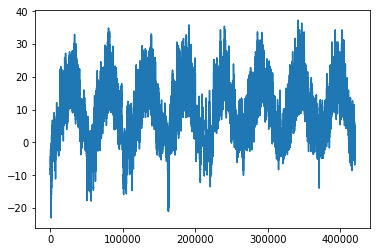

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline

temp = float_data[:, 1]  # температура
plt.plot(range(len(temp)), temp)
plt.show()

На этом графике вы можете четко увидеть годовую периодичность температуры.

Вот более узкий график данных о температуре за первые десять дней (поскольку данные записываются каждые десять минут, мы получаем 144 точки данных
в день):

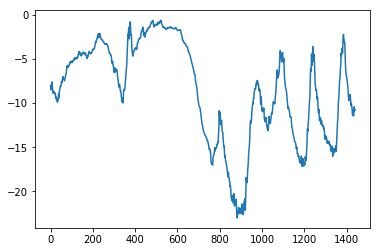

In [7]:
plt.plot(range(1440), temp[:1440])
plt.show()

На этом графике вы можете увидеть ежедневную периодичность, особенно заметную за последние 4 дня. Мы также можем отметить, что этот десятидневный период должен быть
взят из довольно холодного зимнего месяца.

Если бы мы пытались предсказать среднюю температуру для следующего месяца, учитывая данные за несколько месяцев, проблема была бы легкой из-за
достоверной годовой периодичности данных. Но, глядя на данные в масштабе дней, температура выглядит намного более хаотичной. 


## Подготовка данных


Точная формулировка нашей проблемы будет следующей: данные возвращаются к временным шагам `lookback` (временной шаг 10 минут)
и выборка каждые `шаги` временные шаги, мы можем предсказать температуру в `через` несколько временных сдвигов?

Мы будем использовать следующие значения параметров:

* `lookback = 720`, то есть наши наблюдения вернутся на 5 дней назад.
* `steps = 6`, т.е. наши наблюдения будут отбираться в одной точке данных в час.
* `delay = 144`, то есть наши цели в будущем будут через 24 часа.

Для начала нам нужно сделать две вещи:

* Предварительная обработка данных до формата, который нейронная сеть может принять. Это легко: данные уже числовые, поэтому нам не нужно делать никаких
векторизации. Однако каждый временной ряд в данных имеет разный масштаб (например, температура обычно составляет от -20 до +30, но
давление, измеренное в мбар, составляет около 1000). Поэтому мы будем нормализовать каждую временную серию независимо, чтобы все они принимали небольшие значения на
аналогичный масштаб.
* Напишите генератор Python, который берет наш текущий массив данных с плавающей запятой и выдает пакеты данных из недавнего прошлого вместе с
целевая температура в будущем. Поскольку выборки в нашем наборе данных сильно избыточны (например, выборка `N` и выборка` N + 1` будут иметь большинство
их общих временных шагов) было бы очень расточительно явно распределять каждую выборку. Вместо этого мы будем генерировать образцы на
летать, используя оригинальные данные.

Мы предварительно обрабатываем данные путем вычитания среднего значения каждой временной серии и деления на стандартное отклонение. Мы планируем использовать первый
200 000 временных шагов в качестве обучающих данных, поэтому мы вычисляем среднее и стандартное отклонение только для этой части данных:

In [8]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

Теперь вот генератор данных, который мы будем использовать. Он даст кортеж `(samples, target)`, где `samples` - одна партия входных данных и
`target` - соответствующий массив целевых температур. Требуются следующие аргументы:

* `data`: исходный массив данных с плавающей запятой, который мы только что нормализовали в приведенном выше фрагменте кода.
* `lookback`: Сколько временных шагов назад должны пройти наши входные данные.
* `delay`: через сколько шагов прогнозим
* `min_index` и` max_index`: индексы в массиве `data`, которые разграничивают временные шаги для рисования. Это полезно для хранения сегмента
данных для проверки и еще один для тестирования.
* `shuffle`: перетасовать наши образцы или нарисовать их в хронологическом порядке.
* `batch_size`: количество образцов на пакет.
* `step`: период в временных шагах, с которого мы производим выборку данных. Мы установим его на 6, чтобы рисовать одну точку данных каждый час.

In [9]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets


Теперь давайте использовать нашу функцию абстрактного генератора для создания трех генераторов, одного для обучения, одного для проверки и одного для тестирования.
Каждый будет смотреть на разные временные сегменты исходных данных: обучающий генератор просматривает первые 200 000 временных шагов,
генератор проверки просматривает следующие 100 000, а тестовый генератор просматривает остаток.

In [11]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# сколько рисовать точек для валидации
val_steps = (300000 - 200001 - lookback) // batch_size


test_steps = (len(float_data) - 300001 - lookback) // batch_size

## Здравый смысл, базовый уровень без машинного обучения


Прежде чем мы начнем использовать модели глубокого обучения, черный ящик для решения нашей проблемы прогнозирования температуры, давайте попробуем простой здравый смысл. Это послужит проверкой работоспособности и установит базовый уровень, который нам придется превзойти, чтобы продемонстрировать
полезность более продвинутых моделей машинного обучения. Такие здравые смыслы могут быть очень полезны при приближении к новой проблеме для
которого нет никакого известного решения (пока). Классическим примером являются несбалансированные классификационные задачи, где некоторые классы могут быть гораздо более
общие, чем другие. Если ваш набор данных содержит 90% экземпляров класса A и 10% экземпляров класса B, тогда здравый смысл подходит к
задача классификации будет заключаться в том, чтобы всегда предсказать «А» при представлении нового образца. Такой классификатор будет на 90% точным,
и поэтому любой подход, основанный на обучении, должен побить этот 90-процентный балл, чтобы продемонстрировать полезность. Иногда такой элементарный
базовый уровень может оказаться удивительно сложным.

В нашем случае температурные временные ряды можно смело считать непрерывными (завтра температура, вероятно, будет близка к
температура сегодня), а также журнал с ежедневным периодом. Таким образом, подход здравого смысла будет всегда предсказывать, что температура
24 часа будут равны температуре прямо сейчас. Давайте оценим этот подход, используя метрику средней абсолютной ошибки (MAE).
Средняя Абсолютная Ошибка просто равна:

In [10]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.289735972991


## Базовый подход машинного обучения

Точно так же, как полезно установить базовый уровень здравого смысла, прежде чем пробовать подходы машинного обучения, полезно попробовать
простые и дешевые модели машинного обучения (например, небольшие плотно связанные сети), прежде чем изучать сложные и вычислительные
дорогие модели, такие как RNNs. Это лучший способ убедиться, что любая дальнейшая сложность, которую мы добавим к проблеме позже, является законной
и приносит реальную пользу.

Это просто полностьюсвязная модель, в которой мы используем 2 полносвязных слоя. Обратите внимание на отсутствие
функция активации на последнем `Dense` слое, что характерно для регрессионной задачи. Мы используем MAE в качестве потери. Поскольку мы оцениваем
на тех же данных и с той же метрикой, что и при нашем подходе здравого смысла, результаты будут напрямую сопоставимы.

In [17]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 10s - loss: 1.5009 - val_loss: 0.4131
Epoch 2/20
500/500 [==============================] - 10s - loss: 0.4272 - val_loss: 0.2994
Epoch 3/20
500/500 [==============================] - 9s - loss: 0.2837 - val_loss: 0.3115
Epoch 4/20
500/500 [==============================] - 9s - loss: 0.2629 - val_loss: 0.3213
Epoch 5/20
500/500 [==============================] - 9s - loss: 0.2486 - val_loss: 0.3156
Epoch 6/20
500/500 [==============================] - 9s - loss: 0.2405 - val_loss: 0.3144
Epoch 7/20
500/500 [==============================] - 9s - loss: 0.2351 - val_loss: 0.3165
Epoch 8/20
500/500 [==============================] - 9s - loss: 0.2289 - val_loss: 0.3151
Epoch 9/20
500/500 [==============================] - 9s - loss: 0.2248 - val_loss: 0.3238
Epoch 10/20
500/500 [==============================] - 9s - loss: 0.2215 - val_loss: 0.3442
Epoch 11/20
500/500 [==============================] - 9s - loss: 0.2161 - val_loss: 0.

нарисуем наши loss:

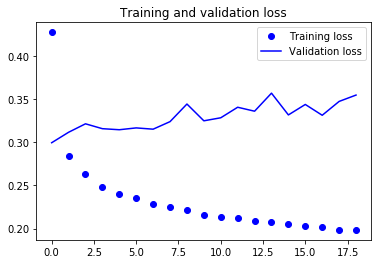

In [23]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Есть точки, где у наша модель сходится к просто модели здравого смысла. Но достаточно волатильно, мы используем знание о цикличности, о чем не знает модель.

Иногда не надо городить огород и можно выехать только на здравом смысле и бизнес-логикой.

## Первая реккурентная сетка


Наш первый полностьюсвязный подход не удался, но это не означает, что машинное обучение не применимо к нашей проблеме. . Давайте вместо этого посмотрим на наши данные
как на последовательность, где причинность и порядок имеют значение. Мы попробуем модель обработки рекуррентной последовательности - она должна  идеально
подходит для такой последовательности данных, именно потому, что она использует временное упорядочение точек данных, в отличие от нашего первого подхода.

Вместо слоя `LSTM`, представленного в предыдущем разделе, мы будем использовать слой` GRU`, разработанный Cho et al. в 2014 году. `GRU` слои
(что означает «gated recurrent unit»), используя тот же принцип, что и LSTM, но они несколько упрощены и, следовательно, дешевле.
 хотя они могут не иметь такой большой представительной силы, как LSTM. Этот компромисс между вычислительной стоимостью и
представительная сила проявляется повсюду в машинном обучении.

In [25]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 169s - loss: 0.3216 - val_loss: 0.2738
Epoch 2/20
500/500 [==============================] - 168s - loss: 0.2846 - val_loss: 0.2654
Epoch 3/20
500/500 [==============================] - 168s - loss: 0.2772 - val_loss: 0.2653
Epoch 4/20
500/500 [==============================] - 168s - loss: 0.2707 - val_loss: 0.2663
Epoch 5/20
500/500 [==============================] - 168s - loss: 0.2643 - val_loss: 0.2680
Epoch 6/20
500/500 [==============================] - 169s - loss: 0.2584 - val_loss: 0.2644
Epoch 7/20
500/500 [==============================] - 168s - loss: 0.2553 - val_loss: 0.2658
Epoch 8/20
500/500 [==============================] - 168s - loss: 0.2508 - val_loss: 0.2672
Epoch 9/20
500/500 [==============================] - 165s - loss: 0.2455 - val_loss: 0.2728
Epoch 10/20
500/500 [==============================] - 164s - loss: 0.2423 - val_loss: 0.2801
Epoch 11/20
500/500 [==============================] - 164s - loss: 0

Рисуем!

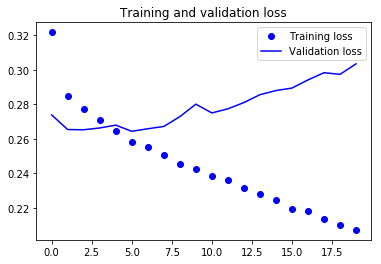

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


Намного лучше! Мы можем значительно превзойти базовый уровень без машинного обучения, демонстрируя ценность машинного обучения здесь, а также
превосходство рекуррентных сетей по сравнению с Dense словями.

Наша новая валидационная MAE ~ 0,265 (до того, как мы начнем значительное переобучения) означает среднюю абсолютную ошибку 2,35 ° C после
денормализация. Это серьезный выигрыш при нашей первоначальной ошибке 2,57 ° C, но у нас, вероятно, все еще есть запас прочности для улучшения.

## Использование периодического dropout для борьбы с переобучением


Из наших кривых обучения и валидации видно, что наша модель переобучается: потери на обучение и валидацию начинают расходиться
значительно после нескольких эпох. Вы уже знакомы с классической техникой борьбы с этим явлением: dropout, состоящий из
произвольное обнуление входных единиц слоя, чтобы нарушить корреляции случайностей в обучающих данных, которым подвергается слой.
Как правильно применить dropout в повторяющихся сетях не является тривиальным вопросом. Давно известно, что применение dropout
в реккуретных сетях препятствует обучению, а не помогает с регуляризацией. В 2015 году Ярин Гал, в рамках своей кандидатской диссертации  по
Байесовскому глубокому обучению определило правильный способ использования dropout с реккуретной сеткой: та же маска отсева (та же схема
обнуления маьоиц) следует применять на каждом временном шаге, вместо маски dropout, которая будет меняться случайным образом от временного шага к временному шагу. Чуть 
подробнее: чтобы упорядочить представления, образованные повторяющимися элементами слоев, таких как GRU и LSTM, временная константy
маску dropout следует применять к внутренним повторяющимся активациям слоя. Используя ту же маску выпадения в
каждый временной шаг позволяет сети правильно распространять свою ошибку обучения во времени; вместо этого временная случайная маска
нарушать этот сигнал ошибки и быть вредным для процесса обучения.

Ярин Гал провел свое исследование с использованием Keras и помог встроить этот механизм непосредственно в рекуррентные слои Keras. Каждый повторяющийся слой в Керасе
имеет два аргумента, связанных с выпадением: `dropout`, число с плавающей точкой, определяющее скорость отсева для входных единиц слоя, и` recurrent_dropout`,
указание показателя отсева повторяющихся единиц. Давайте добавим отсев и повторяющиеся выпадения в наш слой GRU и посмотрим, как это влияет
переобучения. Поскольку для полной конвергенции сетей, регулируемых с помощью dropout, требуется больше времени, мы обучаем нашу сеть вдвое
Эпохи.

In [28]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 171s - loss: 0.3526 - val_loss: 0.2740
Epoch 2/40
500/500 [==============================] - 170s - loss: 0.3138 - val_loss: 0.2742
Epoch 3/40
500/500 [==============================] - 170s - loss: 0.3065 - val_loss: 0.2692
Epoch 4/40
500/500 [==============================] - 170s - loss: 0.3033 - val_loss: 0.2694
Epoch 5/40
500/500 [==============================] - 170s - loss: 0.3006 - val_loss: 0.2695
Epoch 6/40
500/500 [==============================] - 170s - loss: 0.2990 - val_loss: 0.2709
Epoch 7/40
500/500 [==============================] - 170s - loss: 0.2955 - val_loss: 0.2667
Epoch 8/40
500/500 [==============================] - 170s - loss: 0.2942 - val_loss: 0.2671
Epoch 9/40
500/500 [==============================] - 171s - loss: 0.2940 - val_loss: 0.2649
Epoch 10/40
500/500 [==============================] - 170s - loss: 0.2923 - val_loss: 0.2673
Epoch 11/40
500/500 [==============================] - 170s - loss: 0

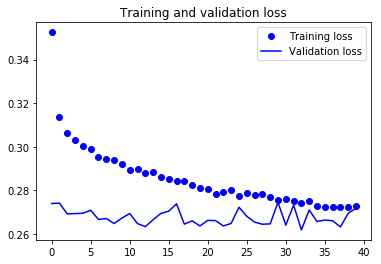

In [33]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Огромный успех; мы больше не переобучаемся в течение первых 30 эпох. Тем не менее, хотя у нас более стабильные оценки, наши лучшие
результаты не намного лучше. чем были ранее.

## Stacking recurrent layers

Поскольку мы больше не переобучаемся, но, похоже, мы столкнулись с узким местом в производительности, мы должны начать рассматривать вопрос об увеличении
нашей сети. Если вы помните наше описание «универсального рабочего процесса машинного обучения»: как правило, рекомендуется увеличить
емкость вашей сети, пока переобучение не станет вашим основным препятствием (при условии, что вы уже предпринимаете основные шаги по смягчению
переобучения, такое как использование dropout). 

Увеличение пропускной способности сети обычно выполняется путем увеличения количества блоков в слоях или добавления большего количества слоев. Stacking recurrent layers - это классический способ построения более мощных рекуррентных сетей: например, то, что в настоящее время поддерживает алгоритм Google translate,
стек из семи больших слоев LSTM - это много.

Чтобы расположить повторяющиеся слои друг над другом в Keras, все промежуточные слои должны возвращать свою полную последовательность выходных данных (трехмерный тензор)
а не их вывод на последнем временном шаге. Это делается указанием `return_sequence = True`:

In [36]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 346s - loss: 0.3341 - val_loss: 0.2780
Epoch 2/40
500/500 [==============================] - 344s - loss: 0.3125 - val_loss: 0.2754
Epoch 3/40
500/500 [==============================] - 344s - loss: 0.3045 - val_loss: 0.2696
Epoch 4/40
500/500 [==============================] - 344s - loss: 0.3018 - val_loss: 0.2747
Epoch 5/40
500/500 [==============================] - 344s - loss: 0.2957 - val_loss: 0.2690
Epoch 6/40
500/500 [==============================] - 344s - loss: 0.2923 - val_loss: 0.2692
Epoch 7/40
500/500 [==============================] - 344s - loss: 0.2907 - val_loss: 0.2673
Epoch 8/40
500/500 [==============================] - 343s - loss: 0.2879 - val_loss: 0.2690
Epoch 9/40
500/500 [==============================] - 343s - loss: 0.2866 - val_loss: 0.2743
Epoch 10/40
500/500 [==============================] - 344s - loss: 0.2833 - val_loss: 0.2669
Epoch 11/40
500/500 [==============================] - 344s - loss: 0

Рисуем!

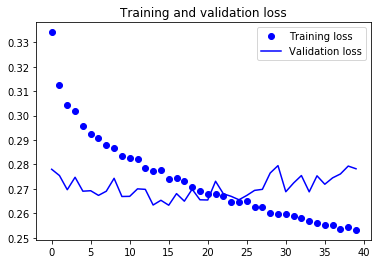

In [37]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()